# Problem Statement


 The Cars dataset contains 16,185 images of 196 classes of cars. The data is split into 8,144 training images and 8,041 testing images, where each class has been split roughly in a 50-50 split. Task is to predict the classes for testing images.


## Dataset

Dataset : [Link](https://ai.stanford.edu/~jkrause/cars/car_dataset.html)



## Get data

In [0]:
#mount google drive in case we need to store data or transfer files

from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [0]:
from pathlib import Path
path = Path('/content/data/')
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/content/data')

In [0]:
!wget -c "http://imagenet.stanford.edu/internal/car196/car_ims.tgz" -P {path}

In [0]:
!wget -c "http://imagenet.stanford.edu/internal/car196/cars_annos.mat" -P {path}

In [0]:
!tar -xf path/'car_ims.tgz'

In [0]:
import os

print ('Number of images:', len(os.listdir(path/'car_ims')))

Number of images: 16185


## Extract labels into a csv

In [0]:
import pandas as pd
from scipy.io import loadmat

def prepare_cars():
    PATH = Path('data/')
    annots = loadmat(PATH/'cars_annos.mat')
    trn_ids, trn_classes, val_ids, val_classes = [], [], [], []
    for annot in annots['annotations'][0]:
        if int(annot[6]) == 1:
            val_classes.append(int(annot[5]))
            val_ids.append(annot[0][0])
        else:
            trn_classes.append(int(annot[5]))
            trn_ids.append(annot[0][0])

    df_trn = pd.DataFrame({'fname': trn_ids, 'class': trn_classes}, columns=['fname', 'class'])
    df_val = pd.DataFrame({'fname': val_ids, 'class': val_classes}, columns=['fname', 'class'])

    combined = df_trn.append(df_val)
    combined.reset_index(inplace=True)
    combined.drop(['index'], 1, inplace=True)
    combined.to_csv(PATH/'annots.csv', index=False)
    df_trn.to_csv(PATH/'train_annots.csv', index=False)
    df_val.to_csv(PATH/'test_annots.csv', index=False)
    
prepare_cars()

In [0]:
import pandas
import random
import imageio
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
df1 = pd.read_csv(path/'train_annots.csv')
df1.head()

,fname,class
0,car_ims/000001.jpg,1
1,car_ims/000002.jpg,1
2,car_ims/000003.jpg,1
3,car_ims/000004.jpg,1
4,car_ims/000005.jpg,1


In [0]:
df2 = pd.read_csv(path/'test_annots.csv')
df2.head()

,fname,class
0,car_ims/000046.jpg,1
1,car_ims/000047.jpg,1
2,car_ims/000048.jpg,1
3,car_ims/000049.jpg,1
4,car_ims/000050.jpg,1


In [0]:
df = pd.read_csv(path/'annots.csv')
df.head()

,fname,class
0,car_ims/000001.jpg,1
1,car_ims/000002.jpg,1
2,car_ims/000003.jpg,1
3,car_ims/000004.jpg,1
4,car_ims/000005.jpg,1


In [0]:
len(df)

16185

## Visualization of samples images

In [0]:
def show_images(img_path, path, rows=2, columns=3):
    
    fig=plt.figure(figsize=(18, 9))
    for i in range(1, columns*rows+1):
        img = imageio.imread(path/img_path[i-1])    
        fig.add_subplot(rows, columns, i)
        plt.imshow(img)
        plt.axis('off')

In [0]:
rnd_images = random.sample(list(df.fname), 6)
rnd_images

['car_ims/007906.jpg',
 'car_ims/003463.jpg',
 'car_ims/007186.jpg',
 'car_ims/005535.jpg',
 'car_ims/004122.jpg',
 'car_ims/002780.jpg']

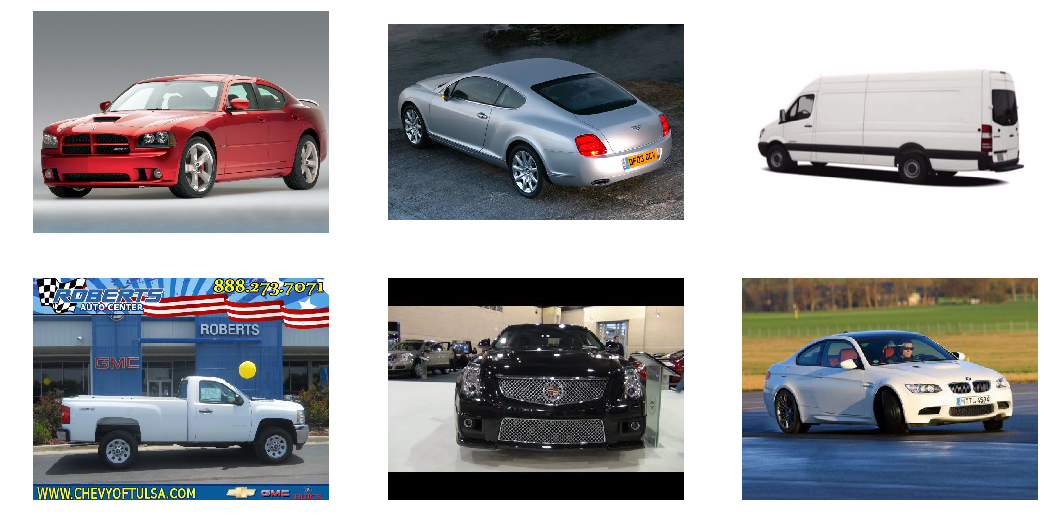

In [0]:
show_images(rnd_images, path)

## Fastai

In [0]:
# import required fastai libraries

from fastai.vision import *
import numpy as np
import os
from pathlib import Path

In [0]:
# path to dataset

path = Path('data/').resolve()

In [0]:
# we will apply transformations such as lightining, zoom, changing brightness and
# changing contrast and resizing it to size 224 which is required for resnet50

tfms = get_transforms(do_flip=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.2,
                      xtra_tfms=[brightness(change=(0.5*(1-0.1), 0.5*(1+0.1)), p=0.75),
                                 contrast(scale=(1-0.1, 1/(1-0.1)), p=0.75)])

# batch size
bs = 64

Creating databunch is one the critical steps in fastai. If this step is done properly, all the ride seems smooth down the lane.
If you want to learn more about databunch, look [here](https://blog.usejournal.com/finding-data-block-nirvana-a-journey-through-the-fastai-data-block-api-c38210537fe4).

In [0]:
# fastai datablock where we split data into 20% validation and 80% training

src = (ImageList.from_csv(path, 'annots.csv') #define source of input
       .split_by_rand_pct(0.2)       #ratio of split
       .label_from_df())           #grab the labels from name of df

In [0]:
# create databunch

data = (src.transform(tfms, size=224)  #resize images to 224
        .databunch(bs=bs)              #batch size=64
        .normalize(imagenet_stats))    #normalize data using imagenet mean, std

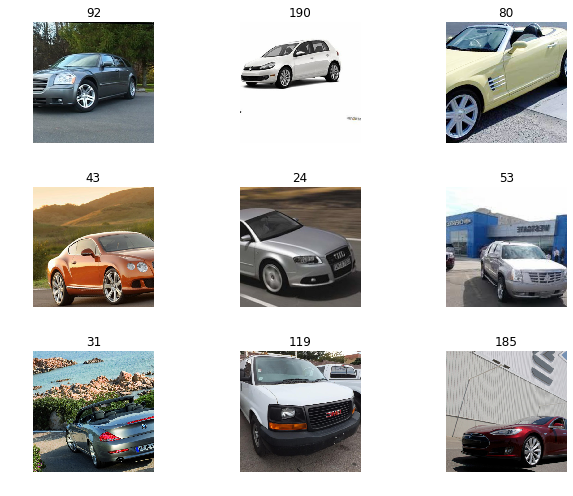

In [0]:
# show me sample images from dataset

data.show_batch(rows=3, figsize=(9, 7))

In [0]:
annots = loadmat(path/'cars_annos.mat')

classes = []
for cl in annots['class_names']:
    classes.append(cl)

classes = classes[0]
print (len(classes))

196
196


In [0]:
classes[31], classes[43], classes[24], classes[80], classes[185]

(array(['BMW X5 SUV 2007'], dtype='<U15'),
 array(['Bentley Continental Flying Spur Sedan 2007'], dtype='<U42'),
 array(['Audi TT RS Coupe 2012'], dtype='<U21'),
 array(['Chrysler PT Cruiser Convertible 2008'], dtype='<U36'),
 array(['Toyota Sequoia SUV 2012'], dtype='<U23'))

In [0]:
# print all the classes and number of classes

print(data.classes)
len(data.classes)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196]


196

## Model

In [0]:
# create a resnet50 architecture with metrics like top-1 accuracy and top-5 accuracy

learn = cnn_learner(data, models.resnet50, metrics=[error_rate, accuracy, top_k_accuracy])
learn.model

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:105: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 98325262.34it/s]


Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_s

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


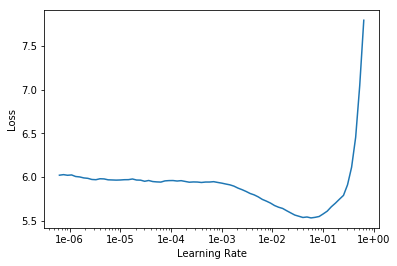

In [0]:
# Step 1: freeze and find learning rate, in this case we choose lr=1e-2

learn.lr_find()
learn.recorder.plot()

In [0]:
# using Cycle policy in super-convergence method, we fit using lr
# obtained from above result for 5 epochs

lr = 1e-2
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,3.654348,2.589935,0.641952,0.358048,0.665431,06:53
1,2.442578,1.611704,0.438060,0.561940,0.852332,06:41
2,1.679283,1.126094,0.315724,0.684276,0.914736,06:32
3,1.203431,0.887742,0.254248,0.745752,0.943466,06:31
4,0.886021,0.822918,0.238492,0.761508,0.945629,06:33


In [0]:
# save the trained model if you don't wan't to redo everything again!

learn.save('/content/224_stage-1')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


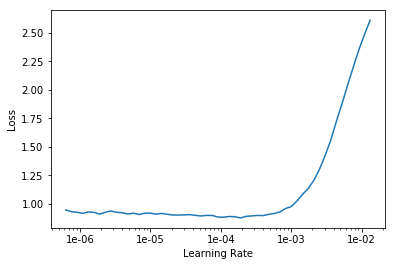

In [0]:
# Step 2: unfreeze and train

learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [0]:
# using cycle policy in super-convergence method we train for 4 epochs

learn.fit_one_cycle(4, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.997054,0.909445,0.258573,0.741427,0.940068,06:46
1,0.868677,0.677510,0.198023,0.801977,0.960148,06:47
2,0.511729,0.483337,0.135619,0.864381,0.977448,06:47
3,0.329811,0.424799,0.127278,0.872722,0.980229,06:47


In [0]:
# save the trained model if you don't wan't to redo everything again!

learn.save('/content/224_stage-2')

In [0]:
# create a backup by copying the saved model to google drive! 
# precaution is better than no caution!

%time !cp "/content/224_stage-2.pth" "/content/drive/My Drive/Colab Notebooks/224_stage-2.pth"

CPU times: user 120 ms, sys: 70.6 ms, total: 191 ms
Wall time: 15.2 s


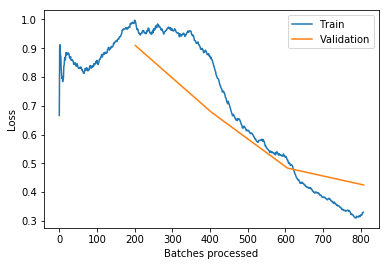

In [0]:
# plot the losses as we can see there is lot of noise in train
# that is due to training on mini-batches and it follows the
# expected trend of train loss less than validation loss 

learn.recorder.plot_losses()

In [0]:
# we reduce the batch size as the size of images will be larger
# change the size from 224 to 512 and load the data in our trained model

bs = bs // 4

data = (src.transform(tfms, size=512)
        .databunch(bs=bs).normalize(imagenet_stats))

learn.data = data

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


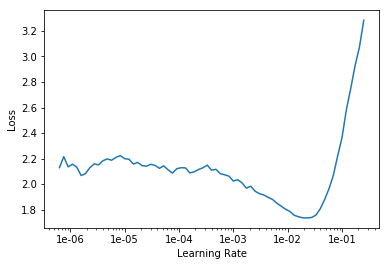

In [0]:
# Step 3: Freeze and train on 512 size images
# We again follow the same lr find method

learn.freeze()
learn.lr_find()
learn.recorder.plot()

In [0]:
# train model for 4 epochs it takes longer time to run than previous

lr = 5e-3
learn.fit_one_cycle(4, slice(lr))

epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.039000,0.625677,0.180723,0.819277,0.967871,15:23
1,0.915611,0.548520,0.153228,0.846772,0.974668,15:16
2,0.629372,0.402172,0.117084,0.882916,0.981464,15:16
3,0.404459,0.354052,0.094532,0.905468,0.982700,15:27


In [0]:
# save model

learn.save('/content/512_stage-1')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


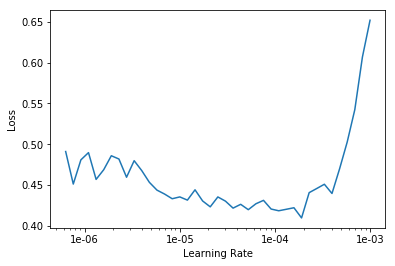

In [0]:
# Step 4: Unfreeze and train

learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [0]:
# last 3 epochs to complete the training procedure

lr = 2e-5
learn.fit_one_cycle(3, slice(1e-6, lr/5))

epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.401469,0.345411,0.095459,0.904541,0.986407,16:17
1,0.372959,0.344100,0.092678,0.907322,0.986098,16:15
2,0.386276,0.338794,0.091752,0.908248,0.984554,16:12


In [0]:
# save model in case we need it for inference

learn.save('/content/512_stage-2')

In [0]:
# as always take precaution by creating a copy

%time !cp "/content/512_stage-2.pth" "/content/drive/My Drive/Colab Notebooks/512_stage-2.pth"

CPU times: user 30.9 ms, sys: 59.2 ms, total: 90.1 ms
Wall time: 3.18 s


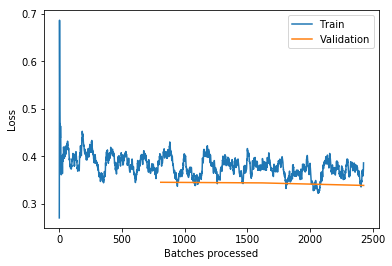

In [0]:
# wow, look at the curves

learn.recorder.plot_losses()

In [0]:
# fancy method in fastai to export all the classes and model architecture
# to file 'export.pkl'

learn.export()

In [0]:
# create a copy of that too!

%time !cp {path}"/export.pkl" "/content/drive/My Drive/Colab Notebooks/export.pkl"

CPU times: user 22.4 ms, sys: 56 ms, total: 78.3 ms
Wall time: 2.38 s


In [0]:
# load export.pkl by specifying the path where export.pkl is located

learn = load_learner(path)

## Interplotion

In [0]:
# tta is fancy method called test time augmentation

interp = ClassificationInterpretation.from_learner(learn, tta=True)

losses,idxs = interp.top_losses()

In [0]:
# we say: tell me where were you looking at to make such prediction
# model replies: I was looking in these areas

interp.plot_top_losses(9, figsize=(15,11))

In [0]:
# how is the confusion in the confusion matrix?

interp.plot_confusion_matrix(figsize=(30, 30), dpi=60)

In [0]:
# where was the model more prone to make mistakes?
# which two classes are creating confusing more and more?

interp.most_confused(min_val=2)

## Testing 

((Category 182,
  tensor(181),
  tensor([8.7562e-07, 5.3052e-06, 8.3743e-09, 7.1790e-06, 3.5243e-07, 2.8718e-07,
          7.7444e-07, 1.2662e-06, 5.1025e-07, 4.6929e-06, 9.3428e-06, 5.7513e-06,
          1.7165e-06, 1.4875e-06, 3.0930e-06, 5.1864e-08, 6.6046e-07, 5.1777e-08,
          8.1738e-05, 4.8584e-05, 3.6649e-05, 1.0244e-04, 1.1688e-05, 4.3217e-07,
          1.9451e-05, 2.2909e-05, 3.8546e-06, 4.3817e-06, 1.1446e-04, 5.2221e-04,
          6.2651e-05, 3.3131e-09, 2.4486e-05, 1.6600e-04, 1.4600e-03, 1.9869e-04,
          3.2443e-06, 4.1922e-05, 1.1365e-05, 5.1143e-06, 7.0903e-07, 9.6828e-06,
          2.8094e-02, 1.8717e-06, 2.6275e-07, 6.5679e-06, 7.1269e-05, 3.1706e-05,
          1.1109e-04, 1.1573e-04, 1.6672e-05, 2.6657e-06, 3.7729e-06, 1.2460e-05,
          5.1833e-08, 2.5921e-04, 2.8072e-07, 1.0071e-05, 1.5697e-05, 1.1497e-07,
          1.1540e-07, 7.2672e-05, 2.5360e-06, 1.1732e-05, 5.5832e-05, 2.2668e-06,
          4.8529e-08, 1.3707e-07, 8.5707e-07, 1.7249e-06, 7.0558e-0

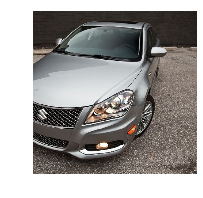

In [0]:
# show me an example from validation set

img = data.valid_ds[0][0]
img.show()
learn.predict(img), learn.data.classes[181], classes[182]

In [0]:
learn.data.classes

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185

In [0]:
# show me sample results
# how well it matches with predictions and ground truth

learn.show_results(rows=5)

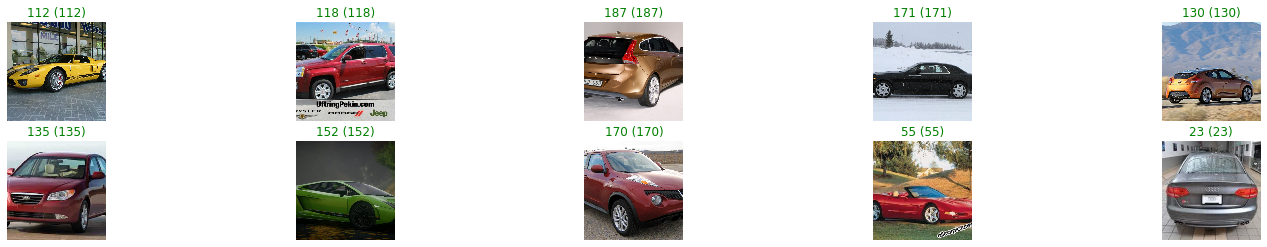

In [0]:
# classes
labels = learn.data.classes

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(10):
    ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
    img = data.valid_ds[idx+np.random.randint(0, len(data.valid_ds)-10)][0]
    preds = learn.predict(img)
    img.show(ax=ax)
    ax.set_title("{} ({})".format(str(learn.data.classes[preds[1]]), str(preds[0])),
                 color=("green" if str(learn.data.classes[preds[1]])==str(preds[0]) else "red"))d